In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [ ]:
df = pd.read_csv('taxi.csv')

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [ ]:
df = df[[
    'Trip Seconds', 'Trip Miles', 'Fare', 'Tips', 'Tolls', 'Extras',
    'Pickup Community Area', 'Dropoff Community Area',
    'Trip Start Timestamp', 'Company', 'Payment Type'
]].dropna()

In [ ]:
# 3. Convert types
df['Trip Seconds'] = df['Trip Seconds'].astype(float)
df['Trip Miles'] = df['Trip Miles'].astype(float)
df['Fare'] = df['Fare'].astype(float)
df['Tips'] = df['Tips'].astype(float)
df['Tolls'] = df['Tolls'].astype(float)
df['Extras'] = df['Extras'].astype(float)
df['Pickup Community Area'] = df['Pickup Community Area'].astype(int)
df['Dropoff Community Area'] = df['Dropoff Community Area'].astype(int)

# 4. Parse Timestamp and extract features
df['Trip Start Timestamp'] = pd.to_datetime(df['Trip Start Timestamp'], errors='coerce')
df['hour'] = df['Trip Start Timestamp'].dt.hour
df['weekday'] = df['Trip Start Timestamp'].dt.weekday
df['month'] = df['Trip Start Timestamp'].dt.month
df['is_rush_hour'] = df['hour'].apply(lambda x: 1 if (7 <= x <= 9) or (16 <= x <= 19) else 0)

# 5. Additional Features
df['trip_minutes'] = df['Trip Seconds'] / 60
df['avg_speed_mph'] = df['Trip Miles'] / (df['trip_minutes'] / 60 + 1e-6)  # avoid div by 0
df['fare_per_mile'] = df['Fare'] / df['Trip Miles']
df['fare_per_minute'] = df['Fare'] / df['trip_minutes']

# 6. Clean outliers
df = df[(df['Fare'] > 2) & (df['Fare'] < 100)]
df = df[(df['Trip Miles'] > 0.1) & (df['Trip Miles'] < 50)]
df = df[df['Trip Seconds'] > 30]
df = df[(df['avg_speed_mph'] < 100)]  # remove unrealistic speeds

# 7. Encode categorical features
df = pd.get_dummies(df, columns=['Company', 'Payment Type'], drop_first=True)

# 8. Define features
feature_cols = [
    'Trip Seconds', 'Trip Miles', 'Pickup Community Area', 'Dropoff Community Area',
    'Tips', 'Tolls', 'Extras', 'hour', 'weekday', 'month', 'is_rush_hour',
    'trip_minutes', 'avg_speed_mph', 'fare_per_mile', 'fare_per_minute'
] + [col for col in df.columns if col.startswith('Company_') or col.startswith('Payment Type_')]

X = df[feature_cols]
y = df['Fare']

# 9. Split and Train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# 10. Evaluate
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse:.2f}")
print(f"Root Mean Squared Error: {rmse:.2f}")
print(f"R² Score: {r2:.4f}")

/tmp/ipython-input-38-1097826049.py:12: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Trip Start Timestamp'] = pd.to_datetime(df['Trip Start Timestamp'], errors='coerce')


Mean Squared Error: 16.07
Root Mean Squared Error: 4.01
R² Score: 0.9288


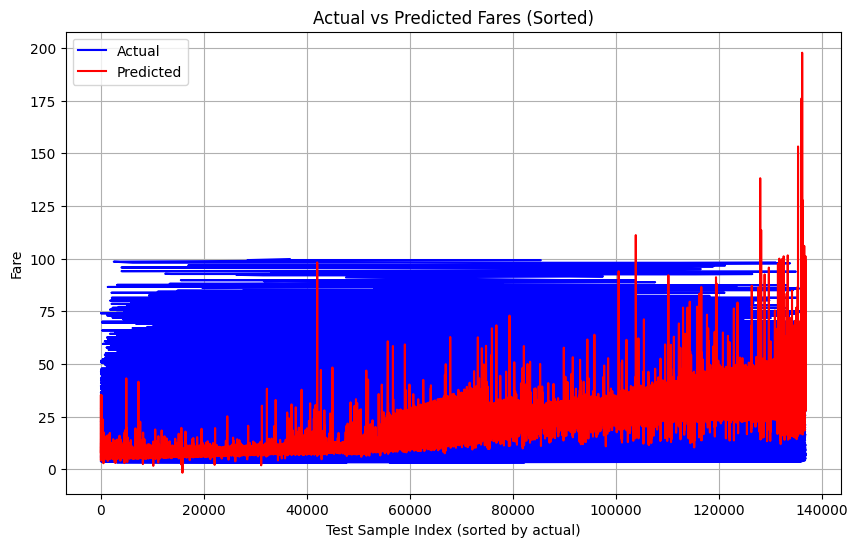

In [ ]:
plt.figure(figsize=(10,6))
sorted_indices = y_test.reset_index(drop=True).sort_values().index
plt.plot(y_test.reset_index(drop=True).sort_values(), label="Actual", color='blue')
plt.plot(pd.Series(y_pred).iloc[sorted_indices].reset_index(drop=True), label="Predicted", color='red')
plt.title("Actual vs Predicted Fares (Sorted)")
plt.xlabel("Test Sample Index (sorted by actual)")
plt.ylabel("Fare")
plt.legend()
plt.grid(True)
plt.show()
